In [0]:
!wget https://www.dropbox.com/s/h1n73cw33no99mz/data.pth

--2020-03-20 15:13:33--  https://www.dropbox.com/s/h1n73cw33no99mz/data.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/h1n73cw33no99mz/data.pth [following]
--2020-03-20 15:13:33--  https://www.dropbox.com/s/raw/h1n73cw33no99mz/data.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc201693bb42369b11c9cee40ce1.dl.dropboxusercontent.com/cd/0/inline/A0Sum2UgcEP9R-yaqAHt9icPPs0p1wSWdH10OvFzhBRVgorCxCfjxOXZDzC7qfFzf0wfmJWTGdk6_mbovb0xm0FD-A0zKFGw9ernuDfRi178nM3x68QfoQDp76n_A9NnNCI/file# [following]
--2020-03-20 15:13:33--  https://uc201693bb42369b11c9cee40ce1.dl.dropboxusercontent.com/cd/0/inline/A0Sum2UgcEP9R-yaqAHt9icPPs0p1wSWdH10OvFzhBRVgorCxCfjxOXZDzC7qfFzf0wfmJWTGdk6_mbovb0xm0FD-A0zKFGw9ernuDfRi178nM3x68QfoQDp76n_A9

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [0]:
train_x, train_y, dev_x, dev_y, test_x = torch.load('data.pth')

print('Training size:', train_x.shape, train_y.shape)
print('Development size:', dev_x.shape, dev_y.shape)
print('Test size:', test_x.shape)

Training size: (45000, 3, 32, 32) (45000,)
Development size: (5000, 3, 32, 32) (5000,)
Test size: (10000, 3, 32, 32)


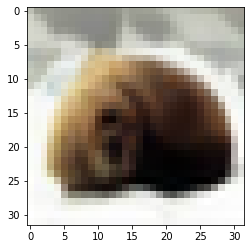

In [0]:
import random
random.seed(0)
sample_num =random.randint(1,len(train_x))
image = train_x[sample_num]
image_ = Variable(torch.from_numpy(image))
image_ = torch.unsqueeze(image_.permute(1, 2, 0), 0)
plt.imshow(image_.detach().cpu().numpy().squeeze())

In [0]:
def normalize_stats_image_by_image(images):
  mean = images.mean(axis=(1,2), keepdims=True)
  stdev = images.std(axis=(1,2), keepdims=True)
  return (images - mean) / (images.max() - images.min())
  
train_images = normalize_stats_image_by_image(train_x)
dev_images = normalize_stats_image_by_image(dev_x)
test_images = normalize_stats_image_by_image(test_x)

In [0]:
trx = Variable(torch.from_numpy(train_images))
dx = Variable(torch.from_numpy(dev_images))
tex = Variable(torch.from_numpy(test_images))
print(trx.shape)

torch.Size([45000, 3, 32, 32])


In [0]:
torch.cuda.is_available()
torch.cuda.empty_cache() 

In [0]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)#输入3通道，输出6通道，kernelsize=5
        #通过stride可以定义每次卷积移动的步长
        self.pool = nn.MaxPool2d(2, 2)
        #通过池化对信息进行筛选过滤
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)

        #self.fc0 = nn.Linear(16 *5*5,10)
        
        #也可以直接进行输出，不用全连接层
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256, 100)
 
    def forward(self, x):
        #print(0,x.size())
        x = self.pool(F.relu(self.conv1(x)))
        #print(1,x.size())
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        #print(2,x.size())
        # fully connect
        x = x.view(x.size(0), -1) 
       # x = self.fc0(x)
       # print(3,x.size())
        x = F.relu(self.fc1(x))
       # print(4,x.size())
        x = F.relu(self.fc2(x))
       # print(5,x.size())
        x = self.fc3(x)
       # print(6,x.size())
        return x
    



In [0]:
model = Net()
model.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=100, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [0]:
def train_step(batch_size=128):
  
  model.train()

  input_batch, label_batch = batch(batch_size, training=True)
  #print(input_batch)
  output_batch = model(input_batch)
  #print(output_batch)
  loss = F.cross_entropy(output_batch, label_batch)
  train_loss = loss.item()
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  #correct = pred_batch.eq(output_batch).cpu().sum()
  #error_rate =1.0 - correct

  optimizer.zero_grad()
  loss.backward()
  
  optimizer.step()
  
  return train_loss, error_rate.item()#loss.item(), error_rate.item()

In [0]:
def val(batch_size=100):
  
  model.eval()
  input_batch, label_batch = batch(batch_size, training=False)
  output_batch = model(input_batch)

  loss = criterion(output_batch, label_batch)
  test_loss = loss.item()
  #print(loss)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  #correct = pred_batch.eq(output_batch).cpu().sum()
  #error_rate =1.0 - correct
  return test_loss, error_rate.item() #loss.item(), error_rate.item()

In [0]:
def batch(batch_size, training=True):
  """Create a batch of examples.
  
  This creates a batch of input images and a batch of corresponding
  ground-truth labels. We assume CUDA is available (with a GPU).
  
  Args:
    batch_size: An integer.
    training: A boolean. If True, grab examples from the training
      set; otherwise, grab them from the validation set.
  
  Returns:
    A tuple,
    input_batch: A Variable of floats with shape
      [batch_size, 1, height, width]
    label_batch: A Variable of ints with shape
      [batch_size].
  """
  if training:
    random_ind = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    input_batch = train_images[random_ind]
    label_batch = train_y[random_ind]
  else:
    input_batch = dev_images[:batch_size]
    label_batch = dev_y[:batch_size]
  
  #input_batch = input_batch[:, np.newaxis, :, :]
  
  input_batch = torch.tensor(input_batch, requires_grad=False, device='cuda').type(torch.FloatTensor).cuda()
  label_batch = torch.tensor(label_batch, requires_grad=False, device='cuda')
  #print(input_batch.shape)
  return input_batch, label_batch


Step     0: Obtained a best validation error of 0.970.
Step   200: Obtained a best validation error of 0.960.
Step   539: Obtained a best validation error of 0.950.
Step   908: Obtained a best validation error of 0.940.
Step  1044: Obtained a best validation error of 0.930.
Step  1356: Obtained a best validation error of 0.920.
Step  1362: Obtained a best validation error of 0.910.
Step  1364: Obtained a best validation error of 0.900.
Step  1706: Obtained a best validation error of 0.890.
Step  3185: Obtained a best validation error of 0.880.
Step  3186: Obtained a best validation error of 0.870.
Step  4446: Obtained a best validation error of 0.860.
Step  4625: Obtained a best validation error of 0.850.
Step  4945: Obtained a best validation error of 0.840.
Step  5005: Obtained a best validation error of 0.830.
Step  5006: Obtained a best validation error of 0.820.
Step  6530: Obtained a best validation error of 0.790.
Step  9247: Obtained a best validation error of 0.770.
Step  9689

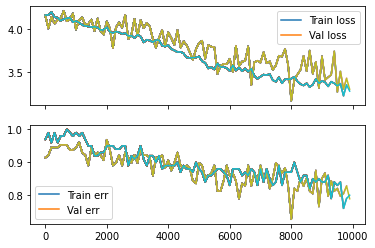

In [0]:
# Let's make sure we always start from scratch (that is,
# without starting from parameters from a previous run).
#for module in model.children():
  #module.reset_parameters()

info = []
fig, ax = plt.subplots(2, 1, sharex=True)
num_steps = 10000
num_steps_per_val = 100
best_val_err = 1.0
for step in range(num_steps):
  train_loss, train_err = train_step()
  val_loss, val_err = val()
  if val_err < best_val_err:
    best_val_err = val_err
    print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
  if step % num_steps_per_val == 0:
    #print(val_loss)
    info.append([step, train_loss, val_loss, train_err, val_err])
    x, y11, y12, y21, y22 = zip(*info)
    ax[0].plot(x, y11, x, y12)
    ax[0].legend(['Train loss', 'Val loss'])
    ax[1].plot(x, y21, x, y22)
    ax[1].legend(['Train err', 'Val err'])
    #ax[1].set_ylim([0.0, 0.25])
    

In [0]:
from typing import List
def write_prediction(prediction: List[int], filename: str):
    with open(filename, 'w') as fp:
        print('Id,Category', file=fp)
        for i, pred in enumerate(prediction):
            print(f'{i},{pred}', file=fp)

In [0]:
test = torch.tensor(test_images, requires_grad=False, device='cuda').type(torch.FloatTensor).cuda()
outputs = model(test)
_,prediction = torch.max(outputs.data, 1)
write_prediction(prediction, 'output.csv')